In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torchbnn as bnn

from sklearn.utils import shuffle
import pickle as pkl
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import os


%matplotlib inline

seed = 1
np.random.seed(seed)

In [2]:
# Create fake dimensions (lat, lon, months, time)
n_years = 10
lats = np.arange(30, 50, 0.5)
lons = np.arange(-10,20, 0.5)
# Change time so the in sample runs -1, 1
time = np.arange(-1,1, (2/12)/n_years) * 2 + 1
months = np.tile(np.arange(-1,1,2/12), n_years)

# Create smooth function to serve as the observational truth
def fun(time, lat, lon, month):
    f = (0.5 * (((lat / 90) ** 2) + 0.5 * np.sin(2 * np.pi * lon / 180)) - 0.2 * np.cos(np.pi * month) + 
         0.1 * np.sin(4 * np.pi * lat / 90) * np.cos(4 * np.pi * lon / 180) - 0.05 * np.cos(2 * np.pi * time) + 0.05 * np.sin(2 * np.pi * lat / 45) * np.sin(2 * np.pi * lon / 90)) 
    return f

obs = np.zeros([len(time), len(lats), len(lons)])
for i, t in enumerate(time):
    for j, lat in enumerate(lats):
        for k, lon in enumerate(lons):
            obs[i, j, k] = fun(t, lat, lon, months[i])
            
# Normalise obs
obs = 2 * (obs - obs.min())/(obs.max() - obs.min()) - 1


# Format data so it is suitable for NN input
data_len = obs.size
lon_data = np.tile(lons, int(data_len / len(lons))).reshape(-1,)
lat_data = np.tile(np.repeat(lats, len(lons)), len(time)).reshape(-1,)
time_data = np.repeat(time, int(data_len / len(time))).reshape(-1,)
mon_data = np.repeat(months, int(data_len / len(time))).reshape(-1,)

# model 1  True in the north with a -0.03 bias
mdl1 = obs.copy() - 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl1[:,:-16, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# model 2 True around equator with no bias
mdl2 = obs.copy() + np.random.normal(size=[len(time),len(lats), len(lons)]) * 0.005 
mdl2[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl2[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 3 True around equator with no bias (as per model 2)
mdl3 = obs.copy() + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl3[:,:16, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1
mdl3[:,-16:, :] = np.random.random([len(time), 16, len(lons)]) * 2 - 1

# model 4 True in the south with 0.03 bias. True only for months 1-6
mdl4 = obs.copy() + 0.03 + np.random.normal(size=[len(time), len(lats), len(lons)]) * 0.005
mdl4[:,16:, :] = np.random.random([len(time), len(lats) - 16, len(lons)]) * 2 - 1

# Add noise
# In the north we have 0.01 noise
obs[:,-16:, :] = obs[:,-16:, :] + np.random.normal(size=obs[:,-16:, :].shape) * 0.01
# Around the equator we have 0.02 noise
obs[:,16:-16, :] = obs[:,16:-16, :] + np.random.normal(size=obs[:,16:-16, :].shape) * 0.02
# In the south we have 0.03 noise
obs[:,:16, :] = obs[:,:16, :] + np.random.normal(size=obs[:,:16, :].shape) * 0.03

df = pd.DataFrame()
df['mdl1'] = mdl1.ravel()
df['mdl2'] = mdl2.ravel()
df['mdl3'] = mdl3.ravel()
df['mdl4'] = mdl4.ravel()

# Convert the coordinates to have a 1:1 mapping
x = np.cos(lat_data * np.pi / 180)  * np.cos(lon_data * np.pi / 180)
y = np.cos(lat_data * np.pi / 180)  * np.sin(lon_data * np.pi / 180)
z = np.sin(lat_data * np.pi / 180)

rads = (mon_data * 360) * (np.pi / 180)
x_mon = np.sin(rads)
y_mon = np.cos(rads)

# Coordinate scaling
df['x'] = x * 2
df['y'] = y * 2
df['z'] = z * 2
df['x_mon'] = x_mon
df['y_mon'] = y_mon
df['time'] = time_data

df['obs'] = obs.ravel()

# Remove last 10 years to see extrapolation
df_in = df[:int(10 * len(df)/20)]
df_out = df[int(10 * len(df)/20):]

df_shuffled = df_in.sample(frac=1, random_state=seed)
split_idx = round(len(df_shuffled) * 0.85)
df_train = df_shuffled[:split_idx]
df_test = df_shuffled[split_idx:]

# In sample training
X_train = df_train.drop(['obs'],axis=1).values
y_train = df_train['obs'].values.reshape(-1,1)

# The in sample testing - this is not used for training
X_test = df_test.drop(['obs'],axis=1).values
y_test = df_test['obs'].values.reshape(-1,1)

# For out of sample extraploation
X_out = df_out.drop(['obs'],axis=1).values
y_out = df_out['obs'].values.reshape(-1,1)

In [3]:
base_dir = "C:/Users/Artgur/Desktop/Uni/MA/BNN/Models/ToyPyModels_BNN_v5/"


num_models = 4
bias_std = 0.01
noise_mean = 0.02
noise_std = 0.004
n_ensembles = 10
hidden_size = 100  # Tune needed 

# Hyperparameters
n = X_train.shape[0]
x_dim = X_train.shape[1]
alpha_dim = x_dim - num_models
y_dim = y_train.shape[1]
learning_rate = 0.00005
n_epochs = 100  # Adjust 
batch_size = 2000

# Initialize standard deviations for weights and biases
init_stddev_1_w = np.sqrt(3 / (x_dim - num_models))
init_stddev_1_b = init_stddev_1_w
init_stddev_2_w = 1.3 / np.sqrt(hidden_size)
init_stddev_2_b = init_stddev_2_w
init_stddev_3_w = (bias_std * 1.3) / np.sqrt(hidden_size)
init_stddev_noise_w = (noise_std * 1.3) / np.sqrt(hidden_size)

lambda_anchor = 1.0 / (np.array([init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w])**2)


X_train = torch.tensor(X_train, dtype=torch.float32).squeeze()
y_train = torch.tensor(y_train, dtype=torch.float32).squeeze()
X_test = torch.tensor(X_test, dtype=torch.float32).squeeze()
X_out  = torch.tensor(X_out, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32).squeeze()
y_out= torch.tensor(y_out, dtype=torch.float32).squeeze()

In [4]:
init_stddev_noise_w

0.0005200000000000001

In [10]:
init_stddev_3_w

0.0013000000000000002

In [39]:
class NN(nn.Module):
    # def __init__(self, x_dim, y_dim, hidden_size, learning_rate, lambda_anchor, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w):
    #     super(NN, self).__init__()
    #     self.spacetime_dim = alpha_dim
    #     self.modelpred_dim = num_models
    #     self.y_dim = y_dim
    #     self.hidden_size = hidden_size
    #     self.learning_rate = learning_rate
    #     self.lambda_anchor = torch.tensor(lambda_anchor, dtype=torch.float32)
        
       
    #     #self.layer_1 = bnn.BayesLinear(prior_mu=0, prior_sigma=init_stddev_1_w, in_features=x_dim, out_features=hidden_size)
    #     #self.layer_2 = bnn.BayesLinear(prior_mu=0, prior_sigma=init_stddev_2_w, in_features=hidden_size, out_features=y_dim)


    #     self.layer_1 = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_1_w, in_features=self.spacetime_dim, out_features=self.hidden_size, bias=True)
    #     # ?? Bayesian batch normalization
    #     self.layer_2 = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_2_w, in_features=self.hidden_size, out_features=self.modelpred_dim, bias=True)

    #     self.modelbias = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_3_w, in_features=self.hidden_size, out_features=self.y_dim, bias=False)
    #     self.noise_pred_layer = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_noise_w, in_features=self.hidden_size, out_features=self.y_dim, bias=False)


    #     # Activation Function
    #     self.tanh = nn.Tanh()
        
    #     # Optimizer
    #     self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    #     # Save initial weights for anchoring
    #     self.initial_weights = [param.data.clone() for param in self.parameters()]




    # def forward(self, x):
    #     modelpred = x[:, :self.modelpred_dim]
    #     spacetime = x[:, self.modelpred_dim:]
    #     #x = self.tanh(self.layer_1_bn(self.layer_1(spacetime)))
    #     x = self.tanh(self.layer_1(spacetime))

    #     model_coeff = torch.softmax(self.layer_2(x), dim=1).squeeze(-1)
        
    #     modelbias = self.modelbias(x).squeeze(-1)  

    #     noise_pred = self.noise_pred_layer(x).squeeze(-1) 

    #     output = torch.sum(model_coeff * modelpred, dim=1) + modelbias.reshape(-1)
        
    #     return output, noise_pred, model_coeff, modelbias



    def __init__(self, x_dim, y_dim, hidden_size, learning_rate, lambda_anchor, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w):
        super(NN, self).__init__()
        self.spacetime_dim = alpha_dim
        self.modelpred_dim = num_models
        self.y_dim = y_dim
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.lambda_anchor = torch.tensor(lambda_anchor, dtype=torch.float32)
        
        self.layer_1 = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_1_w, in_features=self.spacetime_dim, out_features=self.hidden_size, bias=True)
        self.layer_2 = bnn.BayesLinear(prior_mu=0.0, prior_sigma=init_stddev_2_w, in_features=self.hidden_size, out_features=self.modelpred_dim, bias=True)

        self.modelbias = nn.Parameter(torch.randn(self.y_dim) * init_stddev_3_w)
        self.noise_pred = nn.Parameter(torch.randn(self.y_dim) * init_stddev_noise_w)

        self.tanh = nn.Tanh()
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.initial_weights = [param.data.clone() for param in self.parameters()]

    def forward(self, x):
        modelpred = x[:, :self.modelpred_dim]
        spacetime = x[:, self.modelpred_dim:]
        x = self.tanh(self.layer_1(spacetime))

        model_coeff = torch.softmax(self.layer_2(x), dim=1).squeeze(-1)
        
        output = torch.sum(model_coeff * modelpred, dim=1) + self.modelbias
        
        return output, self.noise_pred, model_coeff, self.modelbias

    
    def calculate_loss(self, x, y_target):
        output, noise_pred, _, _ = self.forward(x)
        
        noise_sq = torch.square(noise_pred + noise_mean) + 1e-6
        err_sq = torch.square(y_target.squeeze(-1) - output)
        
        
        #mse_ = torch.sum(err_sq)/ x.shape[0]
        #loss_ = (torch.sum(err_sq / noise_sq) + torch.sum(torch.log(noise_sq)))/ x.shape[0]


        
        mse_ = torch.mean(err_sq)
        loss_ = torch.mean(err_sq / noise_sq) + torch.mean(torch.log(noise_sq))

        # Anchoring Loss
        loss_anchor = 0
        for lambda_val, param, initial_param in zip(self.lambda_anchor, self.parameters(), self.initial_weights):
            loss_anchor += lambda_val * torch.sum((param - initial_param)**2) / x.shape[0]


        
        total_loss =  loss_ + loss_anchor

        return mse_, loss_, loss_anchor, noise_sq, err_sq, total_loss


    def train_step(self, x, y_target):
        self.train()
        self.optimizer.zero_grad()
        mse_loss, noise_loss, loss_anchor, noise_sq, err_sq, total_loss  = self.calculate_loss(x, y_target)
        #total_loss = noise_loss + loss_anchor
        total_loss.backward()
        self.optimizer.step()
        return total_loss.item(), mse_loss.item(), noise_loss.item(), loss_anchor.item() ,noise_sq.mean().item(), err_sq.mean().item()
     
    def get_noise_sq(self, x):
        self.eval()
        with torch.no_grad():
            _, noise_pred, _, _ = self.forward(x)
            noise_sq = torch.square(noise_pred + noise_mean) + 1e-6
        return noise_sq

    def get_alphas(self, x):
        self.eval()
        with torch.no_grad():
            _, _, model_coeff, _ = self.forward(x)
        return model_coeff

    def get_betas(self, x):
        self.eval()
        with torch.no_grad():
            _, _, _, modelbias = self.forward(x)
        return modelbias

    def get_alpha_w(self, x):
        self.eval()
        with torch.no_grad():
            x = self.tanh(self.layer_1(x[:, self.modelpred_dim:]))
            alpha_w = self.layer_2(x)
        return alpha_w

    def get_w1(self, x):
        self.eval()
        with torch.no_grad():
            x = self.tanh(self.layer_1(x[:, self.modelpred_dim:]))
        return x

def predict_ensemble(models, X):
    with torch.no_grad():
        all_preds = torch.stack([model(X)[0] for model in models])
        all_noise_sq = torch.stack([model.get_noise_sq(X) for model in models])

        all_alphas = torch.stack([model.get_alphas(X) for model in models])
        all_betas = torch.stack([model.get_betas(X) for model in models])
        all_alpha_w = torch.stack([model.get_alpha_w(X) for model in models])
        all_w1 = torch.stack([model.get_w1(X) for model in models])

        # all_alpha_w = torch.stack([model.get_alpha_w(X) for model in models])
        # all_w1 = torch.stack([model.get_w1(X) for model in models])


    preds_mu = torch.mean(all_preds, dim=0)
    preds_std = torch.std(all_preds, dim=0)

    return all_preds, preds_mu, preds_std, all_noise_sq, all_alphas, all_betas, all_alpha_w, all_w1


def train_ensemble(X_train, y_train, n_ensembles, n_epochs, batch_size):
    models = []
    num_batches = X_train.shape[0] // batch_size

    for ensemble_index in range(n_ensembles):
        model = NN(x_dim, y_dim, hidden_size, learning_rate, lambda_anchor, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w)

        losses = {
            'total_losses': [],
            'mse_losses': [],
            'noise_losses': [],
            'anchor_losses': [],
        }

        for epoch in range(n_epochs):
            # Shuffle data before each epoch
            permutation = torch.randperm(X_train.shape[0])
            X_train_shuffled = X_train[permutation]
            y_train_shuffled = y_train[permutation]

            epoch_losses = {
                'total_loss': 0,
                'mse_loss': 0,
                'noise_loss': 0,
                'anchor_loss': 0,
                'count': 0
            }

            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = start_idx + batch_size
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]

                loss, mse_loss, noise_loss, anchor_loss, noise_sq, err_sq = model.train_step(batch_x, batch_y)

                epoch_losses['total_loss'] += loss
                epoch_losses['mse_loss'] += mse_loss
                epoch_losses['noise_loss'] += noise_loss
                epoch_losses['anchor_loss'] += anchor_loss
                epoch_losses['count'] += 1

            for key in epoch_losses:
                if key != 'count':
                    corrected_key = key + 'es' if key.endswith('loss') else key + 's'
                    losses[corrected_key].append(epoch_losses[key] / epoch_losses['count'])

            if epoch % 10 == 0:
                print(f"Ensemble {ensemble_index + 1}, Epoch {epoch}, Total Loss: {losses['total_losses'][-1]}, MSE Loss: {np.round(np.sqrt(losses['mse_losses'][-1]),5)}, Noise Loss: {losses['noise_losses'][-1]}, Anchoring Loss: {losses['anchor_losses'][-1]}")
                print(f"noise_sq {noise_sq}, err_sq {err_sq}")

        save_path = f"{base_dir}model_{ensemble_index}_checkpoint.pth"
        save_model(model, model.optimizer, losses, save_path)

        models.append(model)

    return models


def save_model(model, optimizer, losses, save_path="model_checkpoint.pth"):
    save_dict = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,  
    }
    torch.save(save_dict, save_path)
    print(f"Model, optimizer, and losses saved to {save_path}")

    
def recube(in_tensor, lat_len, lon_len, time_len):
    """
    Reshape a flat tensor to a 3D tensor based on dimensions of time, latitude, and longitude.
    """
    output = in_tensor.reshape(time_len, lat_len, lon_len)
    return output

def report_on_percentiles_tensor(y, y_pred, y_std):
    """
    Report the percentage of data points within 1, 2, and 3 standard deviations.
    """
    y, y_pred, y_std = y.flatten(), y_pred.flatten(), y_std.flatten()
    diffs = torch.abs(y_pred - y)
    within_1_std = torch.sum(diffs <= y_std * 1).item() / y.shape[0]
    within_2_std = torch.sum(diffs <= y_std * 2).item() / y.shape[0]
    within_3_std = torch.sum(diffs <= y_std * 3).item() / y.shape[0]

    print(f'Using {y.shape[0]} data points')
    print(f'{within_1_std * 100:.2f}% within 1 std')
    print(f'{within_2_std * 100:.2f}% within 2 std')
    print(f'{within_3_std * 100:.2f}% within 3 std')

def report_on_percentiles(y, y_pred, y_std):

    n = len(y.ravel())

    n1 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 1)
    n2 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 2)
    n3 = np.sum(np.abs(y_pred.ravel() - y.ravel()) <= y_std.ravel() * 3)
    print('Using {} data points'.format(n))
    print('{} within 1 std'.format(100 * n1 / n))
    print('{} within 2 std'.format(100 * n2 / n))
    print('{} within 3 std'.format(100 * n3 / n))

    return

def get_betas(models, X):
    with torch.no_grad():  
        betas = torch.stack([model(X)[3] for model in models])

    #betas_tensor = torch.stack(betas)
    return betas


def get_alphas(models, X):
    with torch.no_grad():
        coeffs = torch.stack([model(X)[2] for model in models]  )
    #coeffs_tensor = torch.stack(coeffs)
    return coeffs

def calculate_rmse(true, pred_mu):
    rmse = torch.sqrt(torch.mean(torch.square(pred_mu - true)))
    return rmse

def calculate_nll(true, pred_mu, pred_std):
    nll = 0.5 * (((pred_mu - true) ** 2) / (pred_std ** 2)) + torch.log(pred_std ** 2) + torch.log(2 * torch.tensor(np.pi))
    return torch.mean(nll)



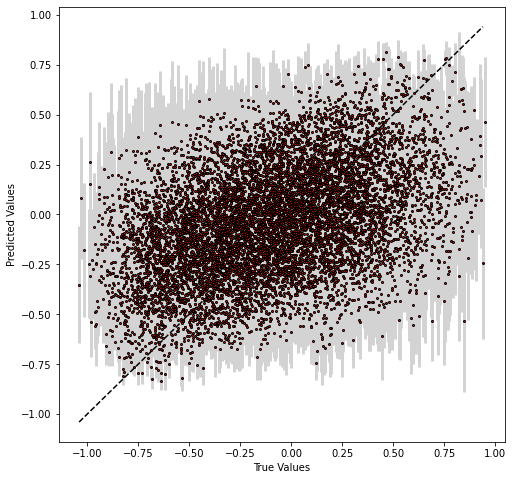

Alpha mean should be: 0.25
Alpha mean is: 0.25
Alpha std should be: 0.19364916731037085
Alpha std is: 0.19792166352272034
Using 400000 data points
63.8375 within 1 std
95.13725 within 2 std
99.9315 within 3 std
Beta mean should be: 0
Beta mean is: -0.0002763944212347269
Beta std should be: 0.01
Beta std is: 0.0014351916033774614
Using 10 data points
60.0 within 1 std
100.0 within 2 std
100.0 within 3 std
For the layers
Layer 1 mean: 0.03185822814702988
Layer 2 mean: 0.02274325117468834
Layer 1 Std: 0.7442517876625061
Layer 2 Std: 1.051072597503662

For noise
Mean noise is: 0.020044032484292984
Mean noise should be: 0.02
Std noise is: 0.000602336716838181
Std noise should be: 0.004
Using 10 data points
100.0 within 1 std
100.0 within 2 std
100.0 within 3 std

For the predictions
Using 10000 data points
31.07% within 1 std
62.23% within 2 std
85.54% within 3 std


In [40]:
models = [NN(x_dim, y_dim, hidden_size, learning_rate, lambda_anchor, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w) for _ in range(n_ensembles)]

X_train_short_tensor = X_train[:10000].clone().detach()

for model in models:

    model.eval()

all_preds, all_preds_mu, all_preds_std, all_noise_sq, all_alphas, all_betas, all_alpha_w, all_w1 = predict_ensemble(models, X_train_short_tensor)

y_train_short = y_train[:10000]

plt.figure(figsize=(8,8))
plt.errorbar(y_train_short, all_preds_mu.numpy()[:10000], yerr=all_preds_std.numpy()[:10000]*1, fmt='o', color='gray', ecolor='lightgray', elinewidth=3, capsize=0, ms=2, mec='black', mfc='red', linestyle='None')
plt.plot(np.arange(min(y_train_short), max(y_train_short), 0.01), np.arange(min(y_train_short), max(y_train_short), 0.01), 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()




alphas_tensor = get_alphas(models, X_train_short_tensor)
alphas_mean = torch.mean(alphas_tensor).item()
alphas_std = torch.std(alphas_tensor).item()

print('Alpha mean should be: {}'.format(1/num_models))
print('Alpha mean is: {}'.format(alphas_mean))
print('Alpha std should be: {}'.format(np.sqrt((1/(1 + num_models)) * (1/num_models)*(1-(1/num_models)))))
print('Alpha std is: {}'.format(np.mean(alphas_std)))
report_on_percentiles(alphas_tensor.numpy(), np.array(1/num_models), np.mean(alphas_std))



betas = get_betas(models, X_train)
betas = betas.numpy()  

beta_mean = np.mean(betas.ravel())
beta_std = np.std(betas.ravel())

print('Beta mean should be: 0')
print(f'Beta mean is: {beta_mean}')
print(f'Beta std should be: {bias_std}')  
print(f'Beta std is: {beta_std}')


report_on_percentiles(betas, np.array(0), beta_std)



print('For the layers')
w1 = all_w1.numpy()
alpha_w = all_alpha_w.numpy()
print('Layer 1 mean: {}'.format(np.mean(w1.ravel())))
print('Layer 2 mean: {}'.format(np.mean(alpha_w.ravel())))
print('Layer 1 Std: {}'.format(np.mean(np.std(w1, axis=0).ravel())))
print('Layer 2 Std: {}'.format(np.mean(np.std(alpha_w, axis=0).ravel())))

print('')

# Noise
print('For noise')
pred_noise = np.sqrt(all_noise_sq.numpy())
print('Mean noise is: {}'.format(np.mean(pred_noise)))
print('Mean noise should be: {}'.format(noise_mean))
print('Std noise is: {}'.format(np.std(pred_noise)))
print('Std noise should be: {}'.format(noise_std))
report_on_percentiles(pred_noise, np.array(noise_mean), np.array(noise_std))

print('')
print('For the predictions')
report_on_percentiles_tensor(y_train_short, all_preds_mu, all_preds_std)


In [41]:
models = train_ensemble(X_train, y_train, n_ensembles, n_epochs, batch_size)

Ensemble 1, Epoch 0, Total Loss: 404.3515089691662, MSE Loss: 0.43242, Noise Loss: 404.34296504786755, Anchoring Loss: 0.008543248713917297
noise_sq 0.0005147688207216561, err_sq 0.18739807605743408
Ensemble 1, Epoch 10, Total Loss: 119.95459822357678, MSE Loss: 0.42995, Noise Loss: 119.94103103387552, Anchoring Loss: 0.01356731445269018
noise_sq 0.0015069423243403435, err_sq 0.18750421702861786
Ensemble 1, Epoch 20, Total Loss: 68.73015994712955, MSE Loss: 0.41783, Noise Loss: 68.72568105478756, Anchoring Loss: 0.004479200151733687
noise_sq 0.0023752921260893345, err_sq 0.15211544930934906
Ensemble 1, Epoch 30, Total Loss: 51.17022035942703, MSE Loss: 0.42765, Noise Loss: 51.167278727547064, Anchoring Loss: 0.0029413701439673294
noise_sq 0.0032586846500635147, err_sq 0.18987196683883667
Ensemble 1, Epoch 40, Total Loss: 36.28991530371494, MSE Loss: 0.4155, Noise Loss: 36.28777791632981, Anchoring Loss: 0.002137212109461915
noise_sq 0.004176835995167494, err_sq 0.20851944386959076
Ense

In [42]:
_, y_preds_mu_train, y_preds_std_train, _,_,_,_,_ = predict_ensemble(models, X_train)
_,y_preds_mu_test, y_preds_std_test, _,_,_,_,_  = predict_ensemble(models, X_test)
_,y_preds_mu_out, y_preds_std_out, _,_,_,_,_  = predict_ensemble(models, X_out)

print('For training')
report_on_percentiles_tensor(y_train, y_preds_mu_train, y_preds_std_train)
print('')
print('For testing')
report_on_percentiles_tensor(y_test, y_preds_mu_test, y_preds_std_test)
print('')
print('For out of sample')
report_on_percentiles_tensor(y_out, y_preds_mu_out, y_preds_std_out)


train_nll = calculate_nll(y_train, y_preds_mu_train, y_preds_std_train)
test_nll = calculate_nll(y_test, y_preds_mu_test, y_preds_std_test)
out_nll = calculate_nll(y_out, y_preds_mu_out, y_preds_std_out)

print('')
print(f'Train NLL: {train_nll.item()}')
print(f'Test NLL: {test_nll.item()}')
print(f'Out of sample NLL: {out_nll.item()}')

train_rmse = calculate_rmse(y_train, y_preds_mu_train )
test_rmse = calculate_rmse(y_test, y_preds_mu_test)
out_rmse = calculate_rmse(y_out, y_preds_mu_out )

print('')
print(f'Train RMSE: {train_rmse.item()}')
print(f'Test RMSE: {test_rmse.item()}')
print(f'Out of sample RMSE: {out_rmse.item()}')

For training
Using 122400 data points
40.60% within 1 std
77.49% within 2 std
96.22% within 3 std

For testing
Using 21600 data points
29.71% within 1 std
59.11% within 2 std
83.49% within 3 std

For out of sample
Using 144000 data points
31.36% within 1 std
61.56% within 2 std
82.12% within 3 std

Train NLL: 0.02090577781200409
Test NLL: 0.6254898905754089
Out of sample NLL: 0.9935650825500488

Train RMSE: 0.36631354689598083
Test RMSE: 0.36959731578826904
Out of sample RMSE: 0.37677738070487976


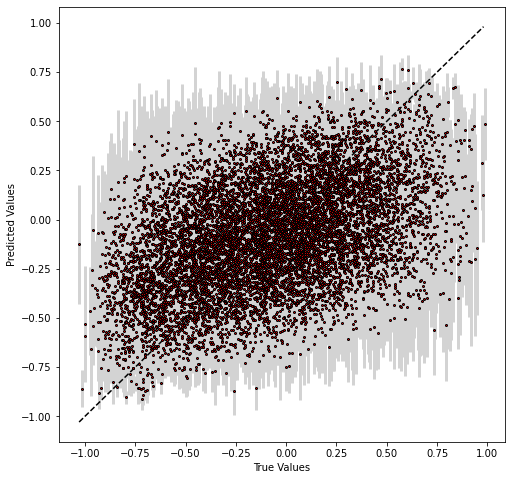

In [45]:
for model in models:

    model.eval()

X_test_short_tensor = X_test[:10000].clone().detach()
all_preds, all_preds_mu, all_preds_std, all_noise_sq, all_alphas, all_betas, all_alpha_w, all_w1 = predict_ensemble(models, X_test_short_tensor)

y_test_short = y_test[:10000]

plt.figure(figsize=(8,8))
plt.errorbar(y_test_short, all_preds_mu.numpy()[:10000], yerr=all_preds_std.numpy()[:10000]*1, fmt='o', color='gray', ecolor='lightgray', elinewidth=3, capsize=0, ms=2, mec='black', mfc='red', linestyle='None')
plt.plot(np.arange(min(y_test_short), max(y_test_short), 0.01), np.arange(min(y_test_short), max(y_test_short), 0.01), 'k--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
stop

In [ ]:
def load_models_from_directory(models_directory):
    
    model_files = [f for f in os.listdir(models_directory) if os.path.isfile(os.path.join(models_directory, f))]
    models = []
    
    for model_file in model_files:
        model_path = os.path.join(models_directory, model_file)
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        model = NN(x_dim, y_dim, hidden_size, learning_rate, lambda_anchor, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, init_stddev_noise_w)
        model.load_state_dict(checkpoint['model_state_dict'])
        models.append(model)
        
    return models


models = load_models_from_directory(base_dir)